<h1> <b> File này dùng để tách dữ liệu thành 2 file train và test: </b> </h1>

- Với file train sẽ crop ra face theo tọa độ bounding box trong file annotation tương ứng.  
- Sau đó tiếp tục tách folder face cropped thành train và test classification cho model HOG + SVM.
- Để đánh giá kết quả phát hiện đối tượng trên tập train, với tập train ban đầu, chủ động lấy khoảng 400 ảnh để kiểm tra kết quả và retrain nếu cần thiết.
- Tóm lại ta có cây thư mục như hình bên dưới

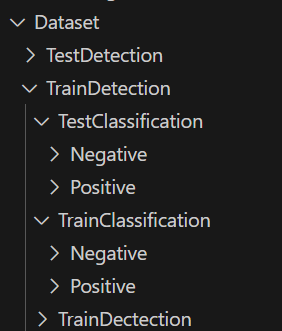

In [1]:
from random import sample
import shutil
import random
import os

random.seed(550805)

In [2]:
def train_test_split(input_folder, train_folder, test_folder, train_size = 0.8):
    """
    Splits all files in the input folder into training and testing sets.
    
    Parameters:
    - input_folder: Path to the input folder containing files to split.
    - train_folder: Path to the folder where training files will be saved.
    - test_folder: Path to the folder where testing files will be saved.
    - train_size: Proportion of files to include in the training set (default is 0.8).
    """
    
    # Create train and test folders if they don't exist
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)
    
    # Get a list of all files in the input folder
    all_files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]
    
    # Calculate the number of training files
    num_train_files = int(len(all_files) * train_size)
    
    # Randomly sample files for the training set
    train_files = sample(all_files, num_train_files)
    
    # Determine test files as those not in the training set
    test_files = [f for f in all_files if f not in train_files]
    
    # Move files to their respective folders
    for f in train_files:
        shutil.move(os.path.join(input_folder, f), os.path.join(train_folder, f))
    
    for f in test_files:
        shutil.move(os.path.join(input_folder, f), os.path.join(test_folder, f))

In [3]:
# Split for the whole project: to detect face
# Faster_RCNN: chỉ cần chạy block này thôi

input_folder = 'InitialData/images'         #folder toàn bộ ảnh (cái mà mình annotate)
train_folder = 'Dataset/TrainDetection'     #folder chứa ảnh để train detection
test_folder = 'Dataset/TestDetection'      #folder chứa ảnh để test detection

train_test_split(input_folder, train_folder, test_folder)

In [6]:
"""
   Từ đây là dành cho hướng HOG + SVM
   Đọc file annotated để crop ảnh trong train_folder
"""
import xml.etree.ElementTree as ET
import cv2

def parse_voc_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []

    name = root.find("filename").text
    
    cnt = 1
    for obj in root.findall("object"):
        bndbox = obj.find("bndbox")
        x0 = int(float(bndbox.find("xmin").text))
        y0 = int(float(bndbox.find("ymin").text))
        x1 = int(float(bndbox.find("xmax").text))
        y1 = int(float(bndbox.find("ymax").text))
        boxes.append([cnt, x0, y0, x1, y1])
        cnt += 1
    return name, boxes

annotated_dir = 'InitialData/Annotations'       #folder chứa các file annotations
image_dir = 'Dataset/TrainDetection'
cropped_dir = 'Dataset/Cropped'                 #folder chứa ảnh đã crop
os.makedirs(cropped_dir, exist_ok=True)

for xml_file in os.listdir(annotated_dir):
    if not xml_file.endswith('.xml'):
        continue
    
    image_name, boxes = parse_voc_xml(os.path.join(annotated_dir, xml_file))
    image_path = os.path.join(image_dir, image_name)
    print(image_path)
    if not os.path.exists(image_path):
        continue

    image = cv2.imread(image_path)
    if image is None:
        continue
    for box in boxes:
        stt, x0, y0, x1, y1 = box
        cropped_image = image[y0:y1, x0:x1]
        cropped_image_name = f"{image_name.split('.')[0]}_crop_{stt}.jpg"
        cv2.imwrite(os.path.join(cropped_dir, cropped_image_name), cropped_image)


# Sau khi đã crop ảnh, ta sẽ chia các ảnh đã crop thành 2 folder train và test để train cho model classification
input_folder = cropped_dir
train_folder = 'Dataset/TrainDetection/TrainClassification/Positive'       #folder chứa ảnh để train classification
test_folder = 'Dataset/TrainDetection/TestClassification/Positive'         #folder chứa ảnh để test classification

train_test_split(input_folder, train_folder, test_folder)

Dataset/TrainDetection\00000003.jpg
Dataset/TrainDetection\00000005.jpg
Dataset/TrainDetection\00000006.jpg
Dataset/TrainDetection\00000008.jpg
Dataset/TrainDetection\00000012.jpg
Dataset/TrainDetection\00000018.jpg
Dataset/TrainDetection\00000020.jpg
Dataset/TrainDetection\00000022.jpg
Dataset/TrainDetection\00000023.jpg
Dataset/TrainDetection\00000024.jpg
Dataset/TrainDetection\00000026.jpg
Dataset/TrainDetection\00000031.jpg
Dataset/TrainDetection\00000032.jpg
Dataset/TrainDetection\00000041.jpg
Dataset/TrainDetection\00000044.jpg
Dataset/TrainDetection\00000047.jpg
Dataset/TrainDetection\00000051.jpg
Dataset/TrainDetection\00000055.jpg
Dataset/TrainDetection\00000058.jpg
Dataset/TrainDetection\00000061.jpg
Dataset/TrainDetection\00000067.jpg
Dataset/TrainDetection\00000069.jpg
Dataset/TrainDetection\00000072.jpg
Dataset/TrainDetection\00000075.jpg
Dataset/TrainDetection\00000082.jpg
Dataset/TrainDetection\00000085.jpg
Dataset/TrainDetection\00000087.jpg
Dataset/TrainDetection\00000

In [9]:
def crop_half_or_quarter(input_folder, output_folder, num_crops_per_image=5):
    os.makedirs(output_folder, exist_ok=True)

    for img_name in os.listdir(input_folder):
        img_path = os.path.join(input_folder, img_name)
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue

        h, w = img.shape[:2]
        img_base = os.path.splitext(img_name)[0]

        for i in range(num_crops_per_image):
            mode = random.choice(['half', 'quarter'])

            if mode == 'half':
                # Chọn 1 trong 2 nửa: trái, phải, trên, dưới
                direction = random.choice(['left', 'right', 'top', 'bottom'])
                if direction == 'left':
                    crop = img[:, 0:w//2]
                elif direction == 'right':
                    crop = img[:, w//2:]
                elif direction == 'top':
                    crop = img[0:h//2, :]
                else:  # bottom
                    crop = img[h//2:, :]
            else:  # quarter
                # Chọn 1 trong 4 góc
                x_start = random.choice([0, w//2])
                y_start = random.choice([0, h//2])
                crop = img[y_start:y_start + h//2, x_start:x_start + w//2]

            crop_name = f"{img_base}_neg_{i}_{mode}.jpg"
            cv2.imwrite(os.path.join(output_folder, crop_name), crop)

# Example usage
input_folder = 'Dataset/TrainDetection/TrainClassification/Positive'           # Folder chứa ảnh mặt người đầy đủ
negative_folder = 'Dataset/NegativeCropped'   # Folder sẽ lưu ảnh crop

crop_half_or_quarter(input_folder, negative_folder, num_crops_per_image=2)


In [10]:
# Sau khi đã crop ảnh, ta sẽ chia các ảnh đã crop thành 2 folder train và test để train cho model classification
input_folder = 'Dataset/NegativeCropped'
train_folder = 'Dataset/TrainDetection/TrainClassification/Negative'       #folder chứa ảnh để train classification
test_folder = 'Dataset/TrainDetection/TestClassification/Negative'         #folder chứa ảnh để test classification

train_test_split(input_folder, train_folder, test_folder)